In [395]:
import os
from typing import Optional

from eval.calculate_samples import StatsScore
from rplan.types import RoomType
from src.eval.make_samples_room_type_cfg import make_samples_room_type_cfg, eval_samples_room_type_cfg
from src.rplan_masks.karras.cfg import CFGUnet, CFGUnetWithScale
from src.rplan_masks.openai.unet import UNetModel
from src.eval.calculate_gt_stats import calculate_gt_stats
from src.eval.make_samples_openai import make_samples_bubbles
import torch
import numpy as np
import re
import matplotlib.pyplot as plt

In [396]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": False,  # Don't interpret text with LaTeX
    "pgf.rcfonts": False,  # Use current matplotlib font
})

In [ ]:
constraints_dir = '/outputs/constraints'

In [398]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [399]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [408]:
def eval_dir(dir_name: str, model_name: str, ranges: Optional[list[tuple[float, float]]] = None,
             allow_more: bool = False):
    if ranges is None:
        ranges = [(0, float('inf'))]
    result_paths = [f for f in os.listdir(dir_name) if f.endswith('.npz')]
    condition_scales = []
    output = [{
        'range': r,
        # 'mean': [[] for _ in range(RoomType.restricted_length())],
        # 'error': [[] for _ in range(RoomType.restricted_length())],
        'mean': [],
        'error': [],
    } for r in ranges]
    for result_path in result_paths:
        full_path = os.path.join(dir_name, result_path)
        match = re.match(fr'{model_name}_([0-9\.]+)\.npz', result_path)
        if match is None:
            continue
        condition_scale = float(match.group(1))
        if condition_scale > 2:
            continue
        results = np.load(full_path)
        input_room_types = results['input_room_types']
        output_room_types = results['output_room_types']
        # x = 3
        # input_room_types = input_room_types[:, x:x+2]
        # output_room_types = output_room_types[:, x:x+2]
        # scores = np.linalg.norm((input_room_types - output_room_types), axis=1)
        num_nonzero = np.count_nonzero(input_room_types, axis=1)
        # scores = np.sum(np.abs(input_room_types - output_room_types), axis=1) / num_nonzero
        if allow_more:
            scores = input_room_types - np.minimum(input_room_types, output_room_types)
        else:
            scores = np.abs(input_room_types - output_room_types)
        # scores = np.abs(input_room_types - output_room_types)
        num_input_rooms = np.sum(input_room_types, axis=1)
        scores = np.sum(scores, axis=1) / num_input_rooms
        if allow_more:
            scores *= 2

        valid_ranges = [(num_input_rooms >= range_start) * (num_input_rooms <= range_end) for range_start, range_end in
                        ranges]
        distributions = [np.sum(valid_range) / len(valid_range) for valid_range in valid_ranges]
        # scores = scores / num_nonzero
        # plt.plot(scores, label=f'condition_scale={condition_scale}')
        # plt.show()
        for range_idx, (range_start, range_end) in enumerate(ranges):
            # for j in range(scores.shape[1]):
            #     diffs = (scores[:, j] * valid_ranges[range_idx])[input_room_types[:, j] > 0]
            #     if len(diffs) == 0:
            #         diffs = np.array([0])
            #     stats = StatsScore(diffs)
            #     output[range_idx]['mean'][j].append(stats.mean)
            #     output[range_idx]['error'][j].append(stats.sem)
            #     output[range_idx]['distribution'] = distributions[range_idx]
            diffs = (scores[valid_ranges[range_idx]]) if np.sum(valid_ranges[range_idx]) > 0 else np.array([0])
            stats = StatsScore(diffs)
            output[range_idx]['mean'].append(stats.mean)
            output[range_idx]['error'].append(stats.sem)
            output[range_idx]['distribution'] = distributions[range_idx]
        condition_scales.append(condition_scale)

    return [
        {
            **r,
            'mean': np.array(r['mean']),
            'error': np.array(r['error']),
        } for r in output
    ], np.array(condition_scales)

In [409]:
def plot_results(results, condition_scales, title: str, filename: str):
    plt.figure(figsize=(8, 4))

    for result in results:
        mean = result['mean']
        error = result['error']
        range_start, range_end = result['range']
        percentage = result['distribution'] * 100

        all = [(condition_scales[i], mean[i], error[i]) for i in
               range(len(condition_scales))]
        all_sorted = sorted(all, key=lambda x: x[0])
        if range_start == 0 and range_end == float('inf'):
            plt.errorbar([x[0] for x in all_sorted], [x[1] for x in all_sorted], yerr=[x[2] for x in all_sorted],
                         label='All Rooms', linewidth=6, fmt='-o')
        else:
            plt.errorbar([x[0] for x in all_sorted], [x[1] for x in all_sorted], yerr=[x[2] for x in all_sorted],
                         label=f'{range_start} Rooms: {percentage:.2f}%', fmt='-o', alpha=0.7)
    plt.legend()
    plt.xlabel('Condition Scale')
    plt.ylabel('Mean Error')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.0, backend='pgf')


def plot_all_results(results_list, title: str, filename: str):
    plt.figure(figsize=(8, 4))

    for name, result_list, condition_scales in results_list:
        for result in result_list:
            mean = result['mean']
            error = result['error']
            range_start, range_end = result['range']

            if not (range_start == 0 and range_end == float('inf')):
                continue

            percentage = result['distribution'] * 100

            all = [(condition_scales[i], mean[i], error[i]) for i in
                   range(len(condition_scales))]
            all_sorted = sorted(all, key=lambda x: x[0])
            plt.errorbar([x[0] for x in all_sorted], [x[1] for x in all_sorted], yerr=[x[2] for x in all_sorted],
                         label=name, fmt='-o', alpha=0.7)

    plt.legend()
    plt.xlabel('Condition Scale')
    plt.ylabel('Mean Error')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.0, backend='pgf')

In [410]:
all_results = []

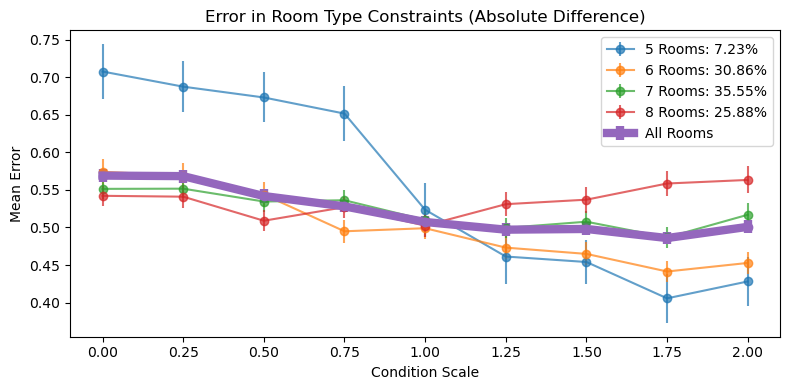

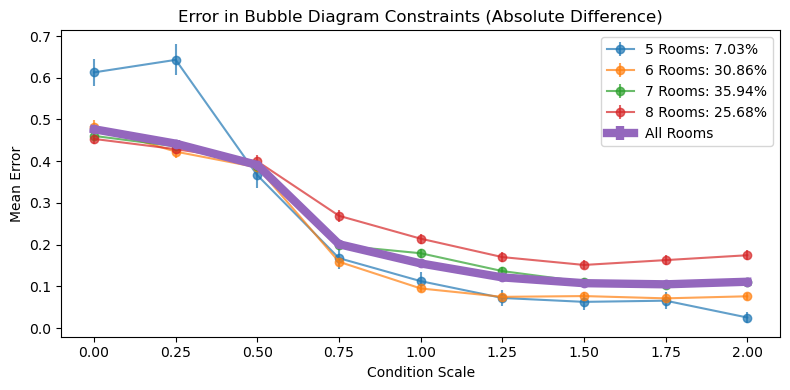

In [411]:
results, condition_scales = eval_dir(
    constraints_dir,
    model_name='sample_room_type_100',
    ranges=[(i, i + 0.8) for i in range(5, 9)] + [(0, float('inf'))])
all_results.append(('Room Types', results, condition_scales))
plot_results(results, condition_scales, title='Error in Room Type Constraints (Absolute Difference)',
             filename='pgf/constraints_error_room_type.pgf')
plt.show()
results, condition_scales = eval_dir(
    constraints_dir,
    model_name='sample_combined_100',
    ranges=[(i, i + 0.8) for i in range(5, 9)] + [(0, float('inf'))])
all_results.append(('Bubble Diagram', results, condition_scales))
plot_results(results, condition_scales, title='Error in Bubble Diagram Constraints (Absolute Difference)',
             filename='pgf/constraints_error_bubbles.pgf')

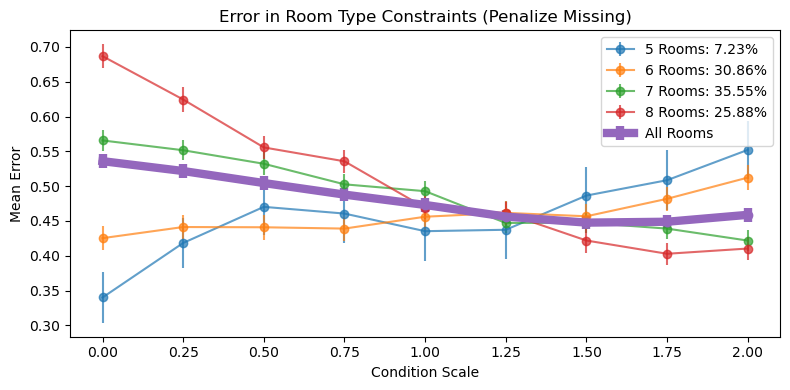

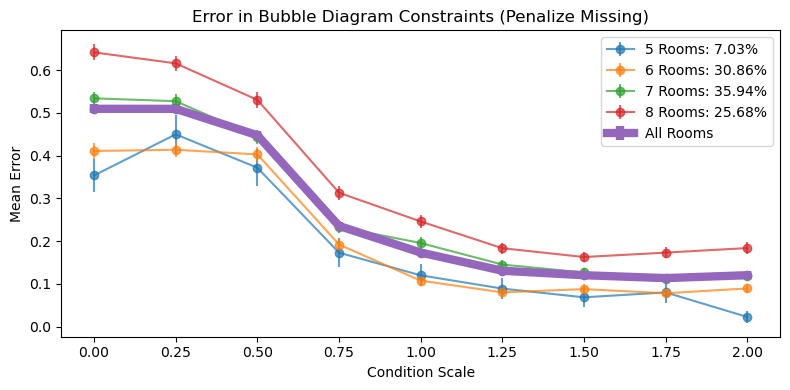

In [412]:
results, condition_scales = eval_dir(
    constraints_dir,
    model_name='sample_room_type_100',
    allow_more=True,
    ranges=[(i, i + 0.8) for i in range(5, 9)] + [(0, float('inf'))])
all_results.append(('Room Types (Allow More)', results, condition_scales))
plot_results(results, condition_scales, title='Error in Room Type Constraints (Penalize Missing)',
             filename='pgf/constraints_error_more_room_type.pgf')
plt.show()
results, condition_scales = eval_dir(
    constraints_dir,
    model_name='sample_combined_100',
    allow_more=True,
    ranges=[(i, i + 0.8) for i in range(5, 9)] + [(0, float('inf'))])
all_results.append(('Bubble Diagram (Allow More)', results, condition_scales))
plot_results(results, condition_scales, title='Error in Bubble Diagram Constraints (Penalize Missing)',
             filename='pgf/constraints_error_more_bubbles.pgf')

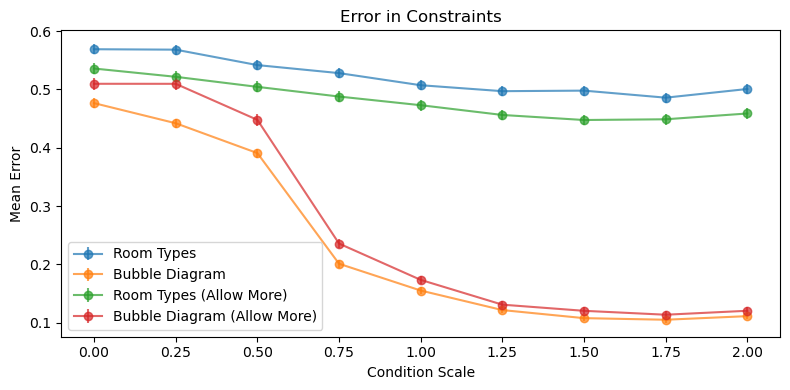

In [413]:
plot_all_results(all_results, title='Error in Constraints',
                 filename='pgf/constraints_error_all.pgf')

In [414]:
all_results[0]

('Room Types',
 [{'range': (5, 5.8),
   'mean': array([0.68735632, 0.40571429, 0.52352941, 0.45405405, 0.7075    ,
          0.42816901, 0.46133333, 0.65151515, 0.67297297]),
   'error': array([0.03424851, 0.03255101, 0.03556379, 0.02963365, 0.03627318,
          0.03291249, 0.03719408, 0.03697428, 0.03323245]),
   'distribution': np.float64(0.072265625)},
  {'range': (6, 6.8),
   'mean': array([0.56878307, 0.44141414, 0.499002  , 0.46482684, 0.57419018,
          0.45280236, 0.47318612, 0.4949187 , 0.54377637]),
   'error': array([0.01689469, 0.01406522, 0.01499242, 0.01532337, 0.01712348,
          0.01407188, 0.01510502, 0.01538291, 0.01717625]),
   'distribution': np.float64(0.30859375)},
  {'range': (7, 7.8),
   'mean': array([0.55161905, 0.48675762, 0.5100321 , 0.50765942, 0.55137126,
          0.51691206, 0.4994316 , 0.53622015, 0.53453689]),
   'error': array([0.01287278, 0.01404714, 0.0140086 , 0.01440588, 0.01355914,
          0.01542671, 0.01342709, 0.01325395, 0.01441704]),